# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic.

In [4]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

Také bude potřeba funkce na update nejlepšího globálního řešení. K tomu si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě.

In [5]:
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

   0: 1.5299
   1: 0.0520
   2: 0.0124
   3: 0.0124
   4: 0.0124
   5: 0.0124
   6: 0.0124
   7: 0.0124
   8: 0.0025
   9: 0.0025
  10: 0.0025
  11: 0.0025
  12: 0.0025
  13: 0.0025
  14: 0.0024
  15: 0.0007
  16: 0.0003
  17: 0.0003
  18: 0.0003
  19: 0.0003
  20: 0.0003
  21: 0.0003
  22: 0.0003
  23: 0.0001
  24: 0.0001
  25: 0.0001
  26: 0.0001
  27: 0.0000
  28: 0.0000
  29: 0.0000
best position
[[-9.41930100e-05 -9.28015798e-05  2.75831368e-04]]


Text(0.5, 0, 'Generace')

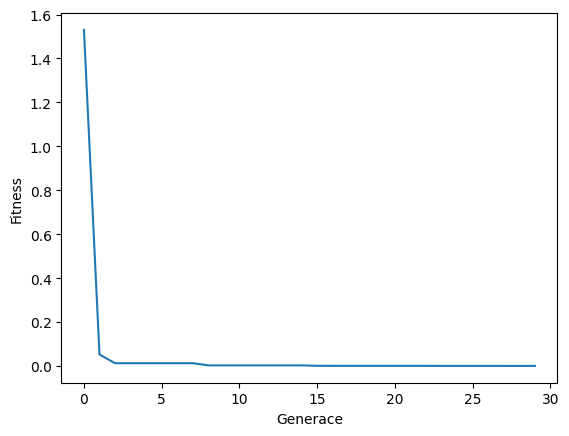

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=3, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrcholy. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [8]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [9]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [10]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [11]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [12]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution


Nyní už si můžeme vytvořit hlavní kód ACO.

In [13]:
def ant_solver(vertices, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [14]:
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

pprint.pprint(vertices)

best_solution, pheromones = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667),
 Vertex(name='Andorra la Vella', x=1.5, y=42.5),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Minsk', x=27.55, y=53.9),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Sarajevo', x=18.36666667, y=43.85),
 Vertex(name='Sofia', x=23.3, y=42.68333333),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Nicosia', x=33.36666667, y=35.15),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Copenhagen', x=12.56666667, y=55.66666667),
 Vertex(name='Tallinn', x=24.73333333, y=59.43333333),
 Vertex(name='Helsinki', x=24.93333333, y=60.16666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Berlin', x=13.36666667, y=52.51666667),
 Vertex(name='Athens', x=23.71666667, y=37.96666667),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Rome', x

 176, 241.5973, 284.6101, 317.2027
 177, 241.5973, 280.8540, 310.4660
 178, 261.0228, 285.7105, 329.1555
 179, 240.1912, 281.1901, 318.2697
 180, 260.3060, 294.9994, 331.6970
 181, 263.4041, 296.5993, 369.5953
 182, 254.9086, 290.0151, 330.8095
 183, 277.6278, 295.0703, 315.6569
 184, 252.7095, 291.8374, 364.6232
 185, 273.5917, 295.9726, 339.6197
 186, 261.0228, 293.4773, 328.3420
 187, 252.7425, 281.4530, 326.1343
 188, 265.3224, 281.6016, 316.9248
 189, 265.3224, 291.6859, 328.1434
 190, 252.7425, 278.2281, 321.7694
 191, 272.1024, 291.6783, 366.1527
 192, 250.2137, 288.6308, 363.3665
 193, 254.8189, 300.2624, 340.9556
 194, 250.2137, 279.3874, 352.3029
 195, 251.0466, 296.6953, 349.8504
 196, 257.5191, 284.2903, 311.7198
 197, 250.2137, 282.4090, 317.4233
 198, 250.2137, 278.4009, 305.7903
 199, 250.2137, 294.0138, 345.5908
 200, 267.6421, 295.4000, 332.1266
 201, 261.0228, 286.5104, 317.4759
 202, 268.4798, 293.1965, 321.8300
 203, 262.3522, 290.7997, 332.6834
 204, 258.4303, 292.

 418, 238.4985, 267.4050, 296.0530
 419, 234.9508, 269.9627, 307.6303
 420, 246.4086, 272.4181, 295.9997
 421, 255.2529, 270.7718, 290.3643
 422, 254.3804, 274.7579, 299.4047
 423, 256.9104, 279.6692, 329.9292
 424, 254.7985, 283.5660, 349.5074
 425, 256.3357, 272.4853, 300.8978
 426, 254.7985, 270.1551, 298.0293
 427, 258.2983, 273.4942, 318.7183
 428, 261.8332, 284.0830, 344.2949
 429, 263.1618, 277.0970, 301.7061
 430, 255.3415, 277.6413, 311.9303
 431, 251.8162, 274.8762, 310.1113
 432, 257.9260, 281.4343, 309.5810
 433, 255.1469, 282.2785, 306.6790
 434, 260.3018, 280.3704, 332.9575
 435, 254.3804, 273.7286, 295.3734
 436, 254.3804, 281.4539, 343.4494
 437, 249.6432, 271.4370, 325.9227
 438, 259.7600, 273.6303, 300.8702
 439, 258.8960, 270.8028, 296.1075
 440, 255.5194, 282.3269, 327.8101
 441, 254.9174, 272.0681, 290.8817
 442, 245.6684, 273.0652, 315.7303
 443, 254.8572, 275.5002, 300.3043
 444, 254.8572, 279.2990, 305.9201
 445, 248.2118, 271.3206, 300.3043
 446, 250.3334, 279.

 658, 271.8167, 294.7483, 338.7464
 659, 274.2657, 300.1374, 333.2239
 660, 268.3974, 290.3987, 317.4933
 661, 271.9727, 295.6107, 343.1385
 662, 283.5243, 293.7907, 321.0247
 663, 264.9313, 286.1900, 303.5622
 664, 272.7497, 294.5658, 331.4258
 665, 272.7497, 294.8611, 323.7327
 666, 292.5962, 317.8180, 341.6465
 667, 279.7247, 307.7838, 348.5390
 668, 269.5601, 306.0574, 363.7784
 669, 269.8029, 290.5040, 341.2918
 670, 272.1486, 292.9028, 333.2272
 671, 253.4237, 288.9378, 332.8752
 672, 273.3159, 301.3726, 341.2150
 673, 275.5158, 294.1498, 327.5844
 674, 287.6480, 306.3397, 331.5593
 675, 268.3974, 298.0280, 339.5578
 676, 286.1331, 300.1190, 333.0047
 677, 282.8079, 312.5098, 384.8548
 678, 281.7696, 296.3842, 326.3729
 679, 270.2037, 300.4466, 327.1392
 680, 270.5263, 292.0068, 326.1978
 681, 269.1925, 304.1853, 338.8654
 682, 273.8309, 306.4757, 331.6336
 683, 268.4106, 294.4313, 341.1269
 684, 282.2837, 311.5685, 338.7489
 685, 283.6311, 305.6652, 332.5551
 686, 279.5862, 303.

 901, 261.9274, 286.5840, 322.5439
 902, 262.0416, 292.1133, 313.3405
 903, 260.8055, 284.7180, 312.4196
 904, 254.7266, 289.1041, 313.1799
 905, 243.9364, 278.8981, 306.0045
 906, 262.6828, 297.7361, 342.5732
 907, 256.4870, 285.5480, 309.9924
 908, 264.6536, 296.6809, 340.6546
 909, 245.3426, 288.2590, 359.3390
 910, 261.9274, 300.7626, 348.5214
 911, 259.8470, 298.0135, 332.2069
 912, 268.3173, 298.9015, 327.6140
 913, 278.7315, 309.5125, 344.6082
 914, 263.4999, 303.7379, 344.6525
 915, 265.1407, 294.5869, 319.7635
 916, 272.1024, 297.3732, 323.8062
 917, 272.1024, 303.1240, 341.2371
 918, 267.7069, 294.4581, 341.9641
 919, 254.3116, 290.7165, 335.3620
 920, 269.6190, 307.3864, 356.2311
 921, 271.5589, 301.3123, 326.9985
 922, 273.8843, 311.5000, 360.4656
 923, 277.6096, 301.8376, 342.0129
 924, 279.7673, 312.9591, 351.1598
 925, 278.1626, 302.0866, 344.7521
 926, 272.5680, 308.5972, 361.7999
 927, 289.4223, 302.4190, 323.8843
 928, 291.6286, 305.3108, 332.6355
 929, 281.3886, 308.

1148, 282.3180, 313.5148, 344.4752
1149, 285.0239, 305.3803, 335.0419
1150, 279.5955, 308.5583, 340.6267
1151, 285.8361, 309.0733, 333.6051
1152, 276.3612, 308.6663, 368.6196
1153, 277.4062, 311.6728, 348.6345
1154, 296.2697, 315.3604, 347.8286
1155, 276.0825, 298.9542, 322.4313
1156, 264.6729, 309.4024, 342.3546
1157, 286.9338, 307.1898, 339.8626
1158, 286.1126, 301.4231, 327.7886
1159, 261.6920, 303.8480, 337.3647
1160, 286.0997, 308.5718, 347.0972
1161, 274.0954, 301.9295, 321.9410
1162, 273.1599, 308.0852, 348.6368
1163, 282.6380, 312.3590, 333.4893
1164, 296.8706, 308.8555, 343.1089
1165, 286.1452, 309.0725, 346.5321
1166, 286.9977, 312.2009, 372.6280
1167, 287.1090, 304.1705, 320.7700
1168, 282.5867, 309.0862, 364.8167
1169, 280.8323, 307.6020, 328.9711
1170, 265.8018, 304.9842, 360.0695
1171, 280.0666, 305.5176, 330.8230
1172, 276.4012, 303.0418, 325.1185
1173, 277.1250, 294.1255, 316.5555
1174, 267.7736, 289.4650, 308.4037
1175, 273.1128, 299.2301, 363.7606
1176, 274.0858, 303.

1385, 251.4612, 283.4035, 340.2985
1386, 256.8243, 290.6118, 326.3834
1387, 256.8243, 286.4276, 341.9033
1388, 270.6601, 294.8262, 320.2940
1389, 252.7261, 287.6949, 336.6907
1390, 275.1062, 294.4383, 330.2751
1391, 252.3704, 287.3404, 315.4408
1392, 252.3704, 283.5789, 328.1239
1393, 256.5732, 291.9078, 352.6299
1394, 252.7261, 284.9266, 317.1153
1395, 261.5853, 281.9931, 345.3584
1396, 251.9438, 283.2692, 323.8079
1397, 253.8462, 276.8302, 325.8901
1398, 249.5970, 283.1630, 322.2334
1399, 259.4375, 275.3675, 301.4884
1400, 253.8462, 278.0932, 303.6592
1401, 268.4979, 304.0990, 369.1449
1402, 252.7261, 288.4909, 319.3830
1403, 255.5798, 286.3888, 369.1048
1404, 256.3561, 294.3529, 324.8218
1405, 255.0577, 288.1705, 337.3492
1406, 256.9083, 307.9097, 355.7142
1407, 255.0577, 295.5536, 342.4835
1408, 269.1097, 294.8399, 350.2043
1409, 253.8462, 306.9219, 357.1999
1410, 253.5913, 275.9017, 299.1269
1411, 254.2774, 291.8861, 322.6494
1412, 240.1359, 299.9983, 371.6360
1413, 270.3450, 289.

1626, 263.0070, 288.1488, 322.3917
1627, 266.3033, 297.9887, 323.5803
1628, 261.6335, 298.6007, 331.8998
1629, 265.8380, 291.5599, 312.5972
1630, 269.5022, 287.2782, 310.6453
1631, 253.0660, 293.9744, 352.2205
1632, 268.4467, 298.1264, 331.5902
1633, 260.6468, 303.0027, 348.4405
1634, 271.3589, 316.7684, 368.5669
1635, 269.6319, 307.7488, 360.2872
1636, 273.2425, 290.5443, 314.9695
1637, 265.8947, 292.4071, 351.6413
1638, 264.6770, 282.1031, 316.3666
1639, 251.7759, 281.0662, 309.5895
1640, 259.0637, 293.1639, 317.0417
1641, 251.7759, 288.4775, 331.1068
1642, 259.5171, 280.7982, 312.9508
1643, 259.4492, 289.0085, 349.2032
1644, 265.5946, 292.2208, 345.2731
1645, 261.7551, 283.9306, 304.9595
1646, 261.3394, 285.8469, 315.0091
1647, 275.4664, 293.2935, 315.6035
1648, 270.6597, 290.5741, 313.8085
1649, 260.4173, 285.6885, 329.9127
1650, 259.6390, 290.2046, 335.0095
1651, 268.0403, 307.4154, 334.6303
1652, 259.0637, 301.4978, 335.3250
1653, 249.3849, 288.9070, 323.7240
1654, 261.1398, 287.

1864, 269.6972, 304.7528, 353.4523
1865, 256.5353, 281.5101, 319.3764
1866, 240.2673, 277.7336, 323.2478
1867, 247.3408, 283.0591, 308.1000
1868, 251.9386, 280.5983, 317.3238
1869, 265.3060, 291.8078, 324.3173
1870, 261.5917, 274.4710, 288.2787
1871, 255.1491, 292.9824, 332.8868
1872, 258.0118, 276.9267, 297.9012
1873, 247.0612, 283.1302, 332.1741
1874, 258.8392, 280.2810, 313.3806
1875, 266.9689, 294.4278, 324.5991
1876, 254.6329, 280.3027, 323.0419
1877, 243.8221, 273.9051, 317.9982
1878, 269.3222, 298.1803, 369.0454
1879, 258.8392, 290.7156, 336.2646
1880, 265.6384, 289.8080, 323.1383
1881, 255.5073, 290.3406, 361.7345
1882, 263.7007, 284.8145, 336.0804
1883, 260.8329, 290.0375, 329.7342
1884, 246.2504, 278.9280, 316.8645
1885, 259.4816, 288.7317, 334.5257
1886, 259.4816, 291.4415, 338.9461
1887, 259.4816, 298.8728, 338.4069
1888, 257.8948, 286.4573, 330.6156
1889, 275.5084, 297.3209, 324.2895
1890, 271.8514, 295.1086, 324.2243
1891, 263.8110, 294.3602, 329.9827
1892, 266.6670, 289.

2099, 260.1516, 286.3124, 364.7976
2100, 273.1418, 308.7247, 345.8698
2101, 259.6581, 286.5307, 330.7250
2102, 275.8120, 310.0802, 347.5474
2103, 260.2260, 299.1502, 374.8095
2104, 257.1033, 285.4191, 312.5396
2105, 268.5008, 296.9697, 318.0132
2106, 274.1270, 285.7927, 297.2364
2107, 265.1058, 290.2709, 311.3746
2108, 262.6447, 293.7077, 345.3417
2109, 262.6447, 292.2154, 328.8205
2110, 259.4185, 277.9061, 318.8604
2111, 261.7239, 297.1209, 337.1914
2112, 257.9338, 278.0798, 297.4512
2113, 259.6860, 302.7500, 334.4874
2114, 259.1844, 301.9963, 351.5209
2115, 278.2367, 313.7280, 351.5826
2116, 263.4874, 287.9820, 333.9350
2117, 259.1844, 295.4296, 336.9686
2118, 263.0114, 294.7616, 348.9962
2119, 267.2374, 292.8716, 379.9448
2120, 260.1451, 289.7882, 336.9790
2121, 266.8074, 298.7644, 328.5426
2122, 264.5658, 297.4413, 341.5574
2123, 263.7090, 291.3404, 340.2850
2124, 263.1184, 297.3297, 338.1266
2125, 261.8095, 299.2323, 329.8101
2126, 261.8095, 293.6586, 341.5574
2127, 265.1548, 302.

2337, 268.4378, 283.9631, 327.0447
2338, 268.2792, 297.4002, 324.1347
2339, 259.0842, 298.2947, 334.2086
2340, 265.3221, 287.9901, 329.3333
2341, 263.6229, 295.3155, 337.2478
2342, 263.9049, 297.8835, 330.2484
2343, 260.1451, 300.2382, 342.6506
2344, 259.5445, 298.5836, 327.8841
2345, 268.4378, 296.4771, 327.2338
2346, 264.4124, 284.2398, 344.2770
2347, 266.6693, 297.0023, 326.3644
2348, 264.6406, 294.5417, 324.7543
2349, 274.6595, 299.6443, 321.9686
2350, 273.3620, 296.9480, 324.2531
2351, 260.1516, 293.0442, 340.5383
2352, 267.0277, 299.4354, 326.3644
2353, 258.1279, 285.0401, 320.1902
2354, 260.4116, 292.0922, 324.7543
2355, 263.9226, 277.0364, 307.2213
2356, 258.0896, 285.5682, 322.7076
2357, 256.7429, 281.5343, 305.6930
2358, 273.1418, 293.2562, 325.4306
2359, 260.4116, 285.8567, 320.7594
2360, 264.5658, 277.1273, 304.4864
2361, 264.4196, 283.4344, 306.8449
2362, 262.0207, 283.4553, 305.7250
2363, 256.5967, 275.3502, 329.3897
2364, 263.6987, 283.3713, 344.2827
2365, 266.5522, 284.

2580, 252.8454, 276.8274, 316.0418
2581, 253.5899, 284.4662, 327.2974
2582, 263.6842, 303.3359, 361.1948
2583, 253.5899, 281.4081, 304.4278
2584, 248.9490, 288.0416, 330.9747
2585, 255.5005, 277.0338, 296.4232
2586, 255.5005, 276.8820, 303.3265
2587, 257.0028, 280.2650, 301.3762
2588, 256.5967, 287.4424, 330.5911
2589, 255.8800, 279.7786, 301.5734
2590, 249.1787, 285.9235, 343.1298
2591, 245.1720, 274.2730, 313.2490
2592, 251.1579, 281.1935, 322.0016
2593, 267.5351, 297.5401, 324.5174
2594, 251.9984, 284.3043, 320.3092
2595, 256.5967, 278.2084, 302.8016
2596, 252.2307, 280.0097, 312.1934
2597, 262.6846, 296.3819, 321.3090
2598, 259.8936, 287.0380, 328.2505
2599, 260.0853, 284.6379, 336.4280
2600, 264.1139, 301.6163, 417.2290
2601, 267.6820, 294.6086, 324.0781
2602, 250.8790, 277.7841, 304.6965
2603, 256.5967, 288.9782, 336.9584
2604, 254.2867, 281.0142, 331.7543
2605, 253.9932, 287.1152, 320.3272
2606, 275.9571, 295.9802, 338.4945
2607, 252.1119, 274.8897, 300.7177
2608, 252.8454, 274.

2816, 265.4781, 294.7507, 339.1908
2817, 264.4146, 292.0586, 337.0609
2818, 269.0621, 290.8913, 331.0433
2819, 265.4781, 286.9609, 302.2160
2820, 263.6493, 289.5816, 315.9448
2821, 251.2506, 288.2187, 325.4948
2822, 270.9069, 282.9066, 302.5942
2823, 266.8141, 285.4176, 315.0992
2824, 266.8141, 292.3491, 321.7684
2825, 272.7406, 297.1449, 340.4278
2826, 288.6917, 311.1361, 355.5060
2827, 257.6924, 299.6504, 351.8981
2828, 255.5169, 293.5849, 312.0453
2829, 239.3492, 281.9270, 316.3404
2830, 240.7553, 285.9510, 326.4722
2831, 237.7668, 283.7500, 315.9641
2832, 264.6218, 300.7830, 342.3979
2833, 268.4486, 289.5502, 316.6253
2834, 255.5169, 293.3698, 345.4913
2835, 260.5343, 295.6818, 336.2548
2836, 240.7553, 288.9700, 335.9509
2837, 262.4425, 282.8291, 309.4948
2838, 271.1558, 299.6763, 316.8238
2839, 265.3614, 296.7718, 322.5581
2840, 239.3492, 279.0983, 318.2057
2841, 239.3492, 276.5666, 324.3609
2842, 237.7668, 271.1691, 310.4667
2843, 248.6412, 270.1220, 297.6608
2844, 253.5958, 289.

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  228.5524738873144
[Vertex(name='London', x=-7.0, y=51.5),
 Vertex(name='Dublin', x=-6.25, y=53.31666667),
 Vertex(name='Paris', x=2.333333333, y=48.85),
 Vertex(name='Brussels', x=4.316666667, y=50.81666667),
 Vertex(name='Amsterdam', x=4.883333333, y=52.36666667),
 Vertex(name='Luxemburg', x=6.116666667, y=49.61666667),
 Vertex(name='Bern', x=7.433333333, y=46.95),
 Vertex(name='Vaduz', x=9.516666667, y=47.13333333),
 Vertex(name='Monaco', x=7.416666667, y=43.73333333),
 Vertex(name='Rome', x=12.5, y=41.88333333),
 Vertex(name='Vatican City', x=12.45, y=41.9),
 Vertex(name='San Marino', x=12.41666667, y=43.93333333),
 Vertex(name='Ljubljana', x=14.5, y=46.05),
 Vertex(name='Zagreb', x=15.96666667, y=45.8),
 Vertex(name='Vienna', x=16.36666667, y=48.21666667),
 Vertex(name='Bratislava', x=17.11666667, y=48.15),
 Vertex(name='Warsaw', x=21.01666667, y=52.25),
 Vertex(name='Budapest', x=19.06666667, y=47.5),
 Vertex(name='Prague', x=14.41666667, y=50.06666667),
 Vertex(name='Be

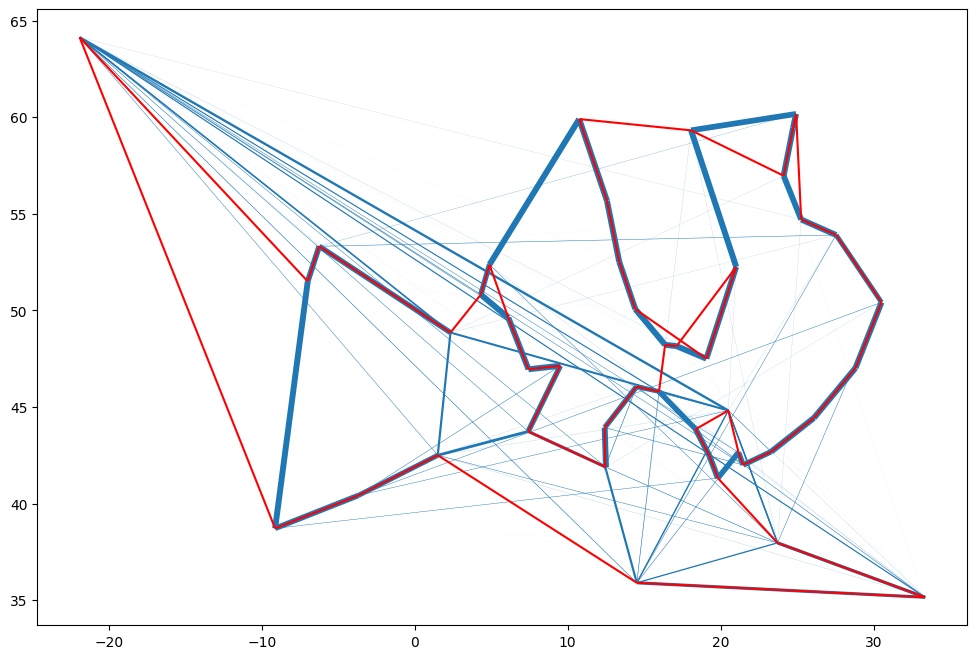

In [15]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Pěkná simulace hledání nejkratší cesty v grafu se nachází [zde](http://thiagodnf.github.io/aco-simulator).

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy. Při nalezení nového zdroje se z nich zase stávají dělnice.

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic. Pro inspiraci je vyřešený například [zde](https://github.com/rwuilbercq/Hive/blob/master/Example2_Rastrigin.py).

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline. Pro sepsání popisu algoritmu a výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/11_rojove%20algoritmy/DU3_spojita_optimalizace.pdf).